In [28]:
# %% [markdown]
# # Автоматизированный пайплайн для House Prices в Jupyter Notebook

# %%
# 1. Импорты
import zipfile
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:

# %%
# 2. Функции пайплайна

def unzip_data(zip_path: Path, extract_dir: Path):
    extract_dir.mkdir(exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)

def load_data(data_dir: Path):
    train = pd.read_csv(data_dir / "train_hw.csv")
    test  = pd.read_csv(data_dir / "test_hw.csv")
    return train, test

def build_preprocessor(train_df: pd.DataFrame):
    """
    Возвращает ColumnTransformer и списки признаков:
    - числовые: SimpleImputer(median) + StandardScaler
    - категориальные: SimpleImputer(constant) + OneHotEncoder(sparse_output=False)
    """
    df = train_df.drop(columns=["Id", "SalePrice"])
    num_feats = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_feats = df.select_dtypes(include=["object"]).columns.tolist()

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_feats),
        ("cat", cat_pipe, cat_feats)
    ])
    return preprocessor, num_feats, cat_feats


In [38]:
# 3. Распаковка и загрузка данных
zip_path = Path("./house-prices-hw.zip")
data_dir = Path("./data")
unzip_data(zip_path, data_dir)
train, test = load_data(data_dir)


In [32]:
# 4. Быстрый обзор и разбиение
pd.set_option('display.max_columns', None)
display(train.head())
print(train.columns.to_list())

print(train.isna().sum()[train.isna().any()].sort_values(ascending=False))

print(train.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,NaN,8750,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1970,1970,Gable,CompShg,MetalSd,MetalSd,BrkFace,76.0,TA,TA,CBlock,TA,TA,No,BLQ,828,Unf,0,174,1002,GasA,TA,Y,SBrkr,1002,0,0,1002,1,0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1973.0,Unf,2,902,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,148500
1,2,160,RM,24.0,2368,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,6,1970,1970,Gable,CompShg,HdBoard,HdBoard,NaN,312.0,TA,TA,CBlock,TA,TA,No,LwQ,765,Unf,0,0,765,GasA,TA,Y,SBrkr,765,600,0,1365,0,0,1,1,3,1,TA,7,Min1,0,NaN,Attchd,1970.0,Unf,2,440,TA,TA,Y,0,36,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,125000
2,3,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,NAmes,Norm,Norm,1Fam,2Story,6,6,1964,1964,Gable,CompShg,HdBoard,HdBoard,BrkFace,360.0,TA,TA,CBlock,TA,TA,Gd,GLQ,674,LwQ,106,0,780,GasA,TA,Y,SBrkr,798,813,0,1611,1,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1964.0,RFn,2,442,TA,TA,Y,328,128,0,0,189,0,NaN,NaN,NaN,0,6,2008,WD,Normal,167900
3,4,120,RM,NaN,4500,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1999,1999,Hip,CompShg,VinylSd,VinylSd,BrkFace,425.0,TA,TA,PConc,Ex,TA,No,GLQ,883,Unf,0,341,1224,GasA,Ex,Y,SBrkr,1224,0,0,1224,1,0,2,0,2,1,TA,5,Typ,0,NaN,Attchd,1999.0,Fin,2,402,TA,TA,Y,0,304,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,165000
4,5,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,SLvl,5,7,1964,1964,Hip,CompShg,Wd Sdng,HdBoard,BrkFace,86.0,TA,TA,PConc,TA,TA,Av,GLQ,1014,Unf,0,138,1152,GasA,TA,Y,SBrkr,1152,0,0,1152,1,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,1964.0,RFn,2,484,TA,TA,Y,227,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500


['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

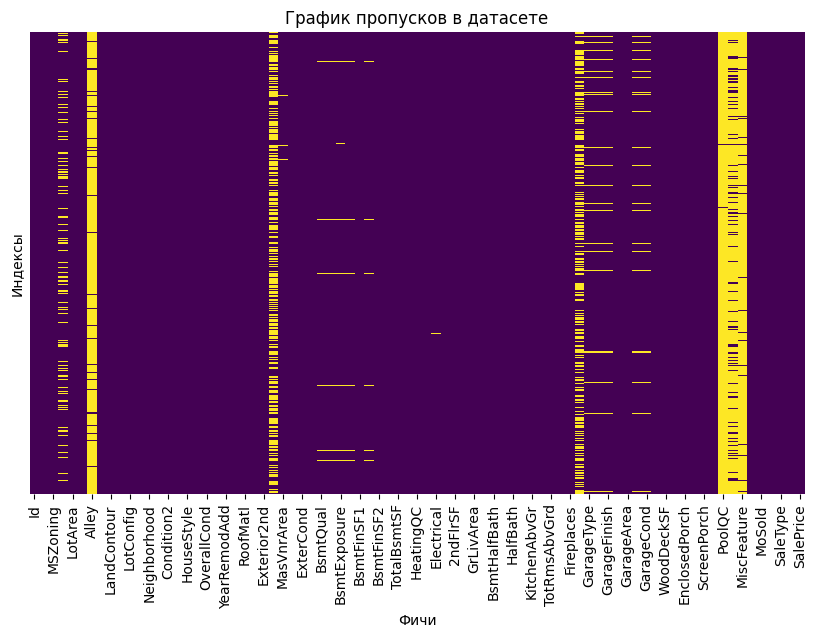

In [29]:
missing_data = train.isnull()

# Строим график
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, cmap='viridis', yticklabels=False)
plt.title('График пропусков в датасете')
plt.xlabel('Фичи')
plt.ylabel('Индексы')
plt.show()

In [33]:
cols = ['Fence', 'MasVnrType', 'FireplaceQu']
for col in cols:
    print(f"{col}: {train[col].unique()}")


Fence: ['MnPrv' nan 'GdWo' 'GdPrv' 'MnWw']
MasVnrType: ['BrkFace' nan 'Stone' 'BrkCmn']
FireplaceQu: [nan 'Gd' 'TA' 'Fa' 'Ex' 'Po']


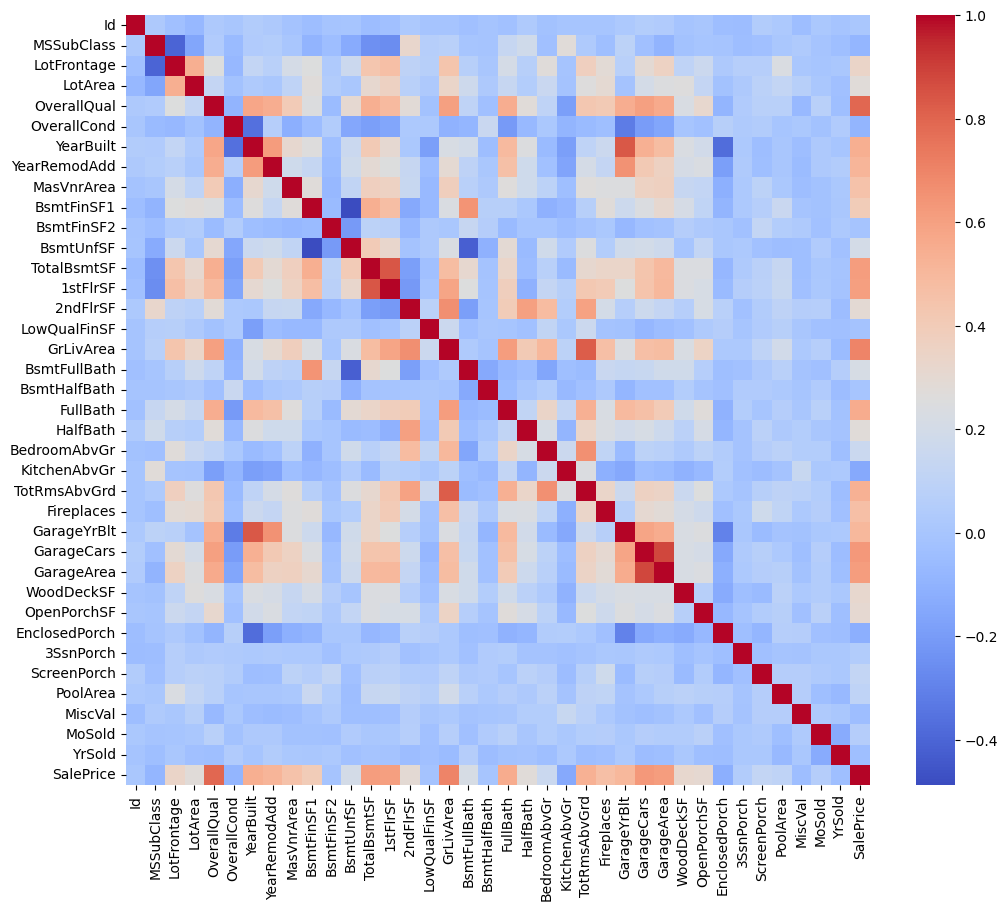

In [39]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()


In [40]:
corr_with_target = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_with_target)

SalePrice        1.000000
OverallQual      0.794936
GrLivArea        0.699296
GarageCars       0.633186
GarageArea       0.614240
TotalBsmtSF      0.613076
1stFlrSF         0.610451
FullBath         0.556587
YearBuilt        0.542835
TotRmsAbvGrd     0.531194
YearRemodAdd     0.516646
GarageYrBlt      0.501015
Fireplaces       0.470805
MasVnrArea       0.452490
BsmtFinSF1       0.398894
LotFrontage      0.341916
WoodDeckSF       0.316417
OpenPorchSF      0.307988
2ndFlrSF         0.291527
HalfBath         0.278424
LotArea          0.276596
BsmtFullBath     0.220574
BsmtUnfSF        0.202656
BedroomAbvGr     0.156718
ScreenPorch      0.121894
PoolArea         0.102506
MoSold           0.057044
3SsnPorch        0.045038
Id               0.010802
BsmtHalfBath    -0.001206
BsmtFinSF2      -0.010826
LowQualFinSF    -0.011578
YrSold          -0.034397
MiscVal         -0.042496
MSSubClass      -0.082230
OverallCond     -0.091854
EnclosedPorch   -0.117258
KitchenAbvGr    -0.140296
Name: SalePr

In [ ]:
train.drop(["PoolQC", "MiscFeature", "Id", "GarageArea"], axis=1, inplace=True)
test.drop(["PoolQC", "MiscFeature", "Id", "GarageArea"], axis=1, inplace=True)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,NaN,8750,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,148500
1,2,160,RM,24.0,2368,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,125000
2,3,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,167900
3,4,120,RM,NaN,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,165000
4,5,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500


Train set:      (934, 81)
Validation set: (234, 81)


In [34]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
print(cat_cols)


['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [6]:

# %% 
# 5. Лог-трансформация целевой переменной
y_train = np.log1p(train_set["SalePrice"])
y_val   = np.log1p(val_set["SalePrice"])
X_train = train_set.drop(columns=["SalePrice", "Id"])
X_val   = val_set.drop(columns=["SalePrice", "Id"])

# %% 
# 6. Построение и применение препроцессора
preprocessor, num_feats, cat_feats = build_preprocessor(train_set)
preprocessor.fit(train_set.drop(columns=["Id", "SalePrice"]))

X_train_proc = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=list(num_feats) +
            list(preprocessor.named_transformers_["cat"]["ohe"]
                 .get_feature_names_out(cat_feats)),
    index=X_train.index
)
X_val_proc = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=X_train_proc.columns,
    index=X_val.index
)

# %% 
# 7. Кросс‑валидация с LightGBM
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    lgb_model,
    pd.concat([X_train_proc, X_val_proc]),
    np.log1p(pd.concat([train_set["SalePrice"], val_set["SalePrice"]])),
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
print("CV RMSE (log1p):", -scores.mean())

# %% 
# 8. Обучение финальной модели и предсказания
lgb_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
)

X_test_proc = pd.DataFrame(
    preprocessor.transform(test.drop(columns=["Id"])),
    columns=X_train_proc.columns,
    index=test.index
)
preds_log = lgb_model.predict(X_test_proc)
preds = np.expm1(preds_log)

# Сохраняем результат
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": preds
})
submission.to_csv("submission.csv", index=False)
print("Done: submission.csv generated")

# %%


CV RMSE (log1p): 0.1360307302550336
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 179
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.021374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

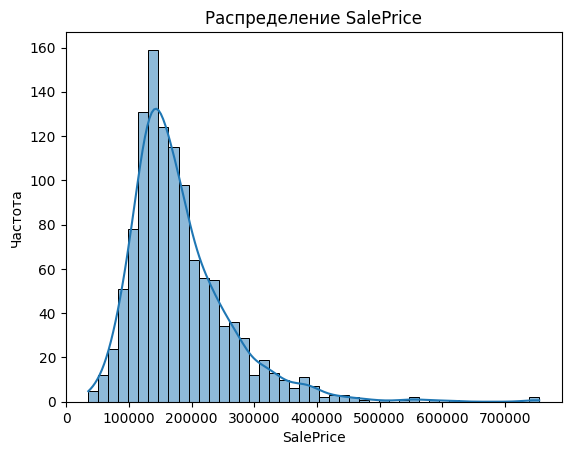

In [41]:
sns.histplot(train['SalePrice'], kde=True)
plt.title('Распределение SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Частота')
plt.show()

In [ ]:
%% 
# 7. Кросс‑валидация с LightGBM
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    lgb_model,
    pd.concat([X_train_proc, X_val_proc]),
    np.log1p(pd.concat([train_set["SalePrice"], val_set["SalePrice"]])),
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
print("CV RMSE (log1p):", -scores.mean())

# %% 
# 8. Обучение финальной модели и предсказания
lgb_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
)

X_test_proc = pd.DataFrame(
    preprocessor.transform(test.drop(columns=["Id"])),
    columns=X_train_proc.columns,
    index=test.index
)
preds_log = lgb_model.predict(X_test_proc)
preds = np.expm1(preds_log)

# Сохраняем результат
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": preds
})
submission.to_csv("submission.csv", index=False)
print("Done: submission.csv generated")

# %%
